
# Parallel Computing and Dijikstra's Algorithm  With Julia: A beginner Approach. 





### By Ivan Felipe Rodriguez .




### High Performance Computing Class Project. 



###  University of Puerto Rico Mayaguez


# Julia

## Quick Reference Guide:

During this work I will be using the following commands:

* @parallel (reducer) : Like the openmp `#pragma parallel for `  This one is often used in for loops.  HOWEVER IS IMPORTANT TO DEFINE THE REDUCER!
* pmaps() : This is a parallel execution for more complicated parallel initializations. 
* SharedArray : This structure is used for shared memory computations. 
* @time : This profile tool measure the time. Shown After the execution. 
* @elapsed : This profile tool measure the time, but does show the output  time rather than the function. 
* @Allocated: This profiling tool measure the allocations in memory. 


## For example 


In [1]:
addprocs()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [21]:

a = zeros(10)
@parallel for i=1:10
  a[i] = i
end
println(a)

[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]


In [2]:
a = SharedArray(Float64,10)
@parallel for i=1:10
  a[i] = i
end
println(a)

[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]


## Problems: 

1. The Algorithm
2. The Implementation 
3. An Example (It works!)
4. The inputs problem 
5. Parallel 
6. The results

## The Algorithm : 

I used the algorithm produced by Madduri et. all. In their paper Parallel Shortest Path Algorihtm for solvin large scale instances. Along with the one by M. Kranjcevic $\Delta$-Stepping Algorithm for Shared Memories Architecture. 

The pseudocode is the following one: 

![](imagenes/algo_1.png)


![](imagenes/algo_2.png)

# Serial Implementation: 

I implemented the following functions. 
* Setup this function basically load the image and prepares the inputs (I will explain this a little bit later) 
* Deltastep. Which performs  the first algorithm. The output are two dictionaries, the first one containing  the tent dictionary which basically keeps the information of how much cost to go from the given node to a different one. And the pred dictionary that will help us getting the path. 
* relax. Which performs the second algorithm
* path :  Taking the second argument from the Deltastep function output it retrieve the minimal path. 


In [12]:

function Deltastep(list,s,delta)
    C=Dict()
    V=Set()
    tent=Dict()
    B=Dict{Any,Set}()
    E=Set()
    heavy=Dict()
    light=Dict()
    Req=[]
    pred=Dict()
    for item in list 
        C[item[1],item[2]]=item[3]
        push!(V,item[1])
        push!(V,item[2])
        push!(E,[item[1],item[2]])
        heavy[item[1]]=[]
        heavy[item[2]]=[]
        light[item[1]]=[]
        light[item[2]]=[]
        tent[item[1]]=10000000000000
        tent[item[2]]=10000000000000
        pred[item[2]]=10000000000000
    end
 
     println("C=$C")

    for e in E
        v=e[1]
        w=e[2]
        if C[v,w]>delta
            push!(heavy[v],e)
        else
            push!(light[v],e)
        end
    end
     println("Heavy: $heavy ")
     println("Light: $light  ")
     println("E=$E")
    relax(s,0,delta,B,tent,pred,1000000000)
    i=0
    while isempty(B)==false
         println("B=$B")
         println("tent=$tent")
         #Processing vertices from B[i]
        if haskey(B,i)==true
            S=Set()
             #Relax recursively all light edges while they stay in B[i]
            while isempty(B[i])==false
                 #Push to Req all light edges from vertices in B[i]
                Req=[]
                for v in B[i]
                     println("v=$v")
                    for e in light[v]
                         println("e=$e")
                        push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                    end
                end
                 #Update S
                union!(S,B[i])
                B[i]=Set()
                
                 #Relax all Req edges
                for r in Req
                     println("r=$r")
                    relax(r[1],r[2],delta,B,tent,pred,r[3])
                end
            end
             #Relax all heavy edges of vertices in S
            Req=[]
            delete!(B,i)
            for v in S
                for e in heavy[v]
                    push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                end
            end
            for r in Req
                relax(r[1],r[2],delta,B,tent,pred,r[3])
            end
        end
        
        i=i+1
    end
    
    println("This is the answer: $tent")
  
    return tent,pred
    
   
end
    

Deltastep (generic function with 1 method)

In [9]:
function relax(w,d,delta,B,tent,pred,v)
    # println("w : $w")

    if d<tent[w]
        old_i=floor(tent[w]/delta)
        tent[w]=d
        
        if (haskey(B,old_i)==true)
            delete!(B[old_i],w)
            
        else
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), B[old_i=$old_i] not found")
        end
        #Add w to new bin and update its tent
        new_i=floor(d/delta)
        if (haskey(B,new_i)==false)
            B[new_i]=Set()
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), allocated B[fld=$new_i].")
        end
        push!(B[new_i],w)
        tent[w]=d
        if (haskey(pred,w)==false)
            pred[w]=()
            pred[w]=v
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), allocated B[fld=$new_i].")
        else 
            pred[w]=v
        end
        
        # println("The previous node visited was: $pred")
    end
end
        

relax (generic function with 1 method)

In [19]:
function path(pred,w)
  v=w
  path = []
  while v<1000000000
        push!(path,v)
        println("$path")
        v = pred[v]
   end
    
    return reverse(path)
end

path (generic function with 1 method)

In [14]:
a=Array{Int64}[]
push!(a,[1,2,1])
push!(a,[2,3,1])
push!(a,[3,1,4])
push!(a,[3,4,2])
push!(a,[4,2,5])

5-element Array{Array{Int64,N},1}:
 [1,2,1]
 [2,3,1]
 [3,1,4]
 [3,4,2]
 [4,2,5]

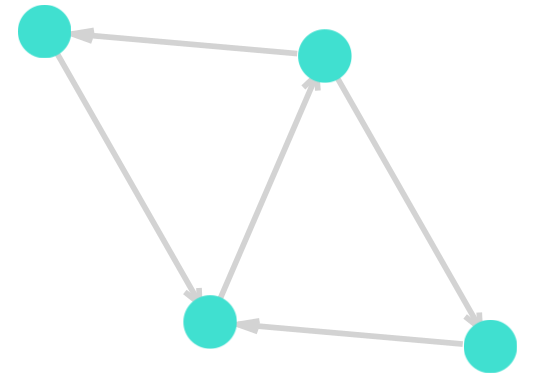

In [6]:
using Graphs,GraphPlot
graph = simple_graph(4)
for e in a
    add_edge!(graph, e[1], e[2])
end
gplot(graph)

In [14]:
(tent,pred)=Deltastep(a,2,1)


C=Dict{Any,Any}((1,2)=>1,(2,3)=>1,(3,1)=>4,(4,2)=>5,(3,4)=>2)
Heavy: Dict{Any,Any}(4=>Any[[4,2]],2=>Any[],3=>Any[[3,1],[3,4]],1=>Any[]) 
Light: Dict{Any,Any}(4=>Any[],2=>Any[[2,3]],3=>Any[],1=>Any[[1,2]])  
E=Set(Any[[3,1],[1,2],[4,2],[3,4],[2,3]])
B=Dict{Any,Set{T}}(0.0=>Set(Any[2]))
tent=Dict{Any,Any}(4=>10000000000000,2=>0,3=>10000000000000,1=>10000000000000)
v=2
e=[2,3]
r=[3,1,2]
B=Dict{Any,Set{T}}(1.0=>Set(Any[3]))
tent=Dict{Any,Any}(4=>10000000000000,2=>0,3=>1,1=>10000000000000)
v=3
B=Dict{Any,Set{T}}(3.0=>Set(Any[4]),5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
B=Dict{Any,Set{T}}(3.0=>Set(Any[4]),5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
v=4
B=Dict{Any,Set{T}}(5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
B=Dict{Any,Set{T}}(5.0=>Set(Any[1]))
tent=Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)
v=1
e=[1,2]
r=[2,6,1]
This is the answer: Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5)


(Dict{Any,Any}(4=>3,2=>0,3=>1,1=>5),Dict{Any,Any}(4=>3,2=>1000000000,3=>2,1=>3))

In [20]:
path(pred,1)

Any[1]
Any[1,3]
Any[1,3,2]


3-element Array{Any,1}:
 2
 3
 1

# Los Inputs

Since we want to process images, I used the following methodology (Code is the setup.jl file). First thing was to cast the information in the proper way. To do so. I define each pixel to be a vertex and each of its possible neighbors are the possible edges coming from that node. The cost is calculate using the gradient of the image. I had first to conver the image into a grayscale. 


  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:61
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/mac/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/mac/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading /Users/mac/.julia/v0.4/ImageView/src/annotations.jl, in expression starting on line 96
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in i

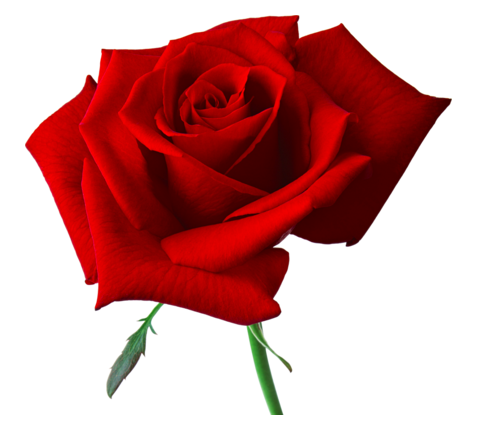

In [1]:
using Images, Colors, FixedPointNumbers, ImageView
Img=load("rose.png") 

In [3]:
Img[28,147]

RGBA{U8}(0.784,0.0,0.055,1.0)

In [4]:
Img[27,146]

RGBA{U8}(0.8,0.0,0.094,1.0)

  likely near In[5]:1


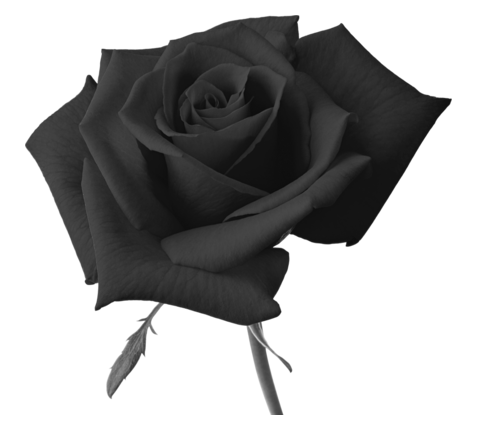

In [5]:
A=convert(Image{Gray{Ufixed8}}, Img)

In [8]:
(x,y)=imgradients(A)

(
Gray Images.Image with:
  data: 491x435 Array{Float64,2}
  properties:
    colorspace: Gray
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1,

Gray Images.Image with:
  data: 491x435 Array{Float64,2}
  properties:
    colorspace: Gray
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1)

In [11]:
using Colors
function setup(A)
	node=Array{Int64}[]
	x,y = size(A)
	list=Array{Float64}[]
	A=convert(Image{Gray{Ufixed8}}, A)
	for i in x:length(A)-x
		
		color1=colordiff(color(A[i]),color(A[i+1]))+1
		edge=[i,i+1,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i-1]))+1
		edge=[i,i-1,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i-y]))+1
		edge=[i,i-y,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i+y]))+1
		edge=[i,i+y,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i-y-1]))+1
		edge=[i,i-y-1,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i-y+1))+1
		edge=[i,i-y+1,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i+y-1))+1
		edge=[i,i+y-1,color1]
		push!(list,edge)
		color1=colordiff(color(A[i]),color(A[i+y+1))+1
		edge=[i,i+y+1,color1]
		push!(list,edge)
		
	end

return list





end


 in trunc at float.jl:374
 in copy! at abstractarray.jl:310
 in convert at /Users/mac/.julia/v0.4/Images/src/core.jl:341
 in _convert at /Users/mac/.julia/v0.4/Images/src/core.jl:462
 in save_ at /Users/mac/.julia/v0.4/QuartzImageIO/src/QuartzImageIO.jl:258
 in getblob at /Users/mac/.julia/v0.4/QuartzImageIO/src/QuartzImageIO.jl:282
 in save at /Users/mac/.julia/v0.4/QuartzImageIO/src/QuartzImageIO.jl:48
 in save at /Users/mac/.julia/v0.4/FileIO/src/loadsave.jl:95
 in writemime at /Users/mac/.julia/v0.4/Images/src/writemime.jl:30
 in base64encode at base64.jl:160
 in display_dict at /Users/mac/.julia/v0.4/IJulia/src/execute_request.jl:32
 in execute_request_0x535c5df2 at /Users/mac/.julia/v0.4/IJulia/src/execute_request.jl:213
 in eventloop at /Users/mac/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
Trying next loading library! Please report this issue on the Github page for QuartzImageIO
 in checked_import at /Users/mac/.julia/v0.4/FileIO/src/loadsave.jl:12
 in sav

InexactError: InexactError()

In [12]:
# Running and Profiling tools 

In [ ]:
using Images, Colors, FixedPointNumbers, ImageView
img=load("rose.png")
include("setup.jl")
include("deltastep.jl")
include("relax.jl")
include("path.jl")
graph=Array{Int64}[]
push!(graph,[1,2,1])
push!(graph,[2,3,1])
push!(graph,[3,1,4])
push!(graph,[3,4,2])
push!(graph,[4,2,5])
Delta=@time Deltastep(graph,2,1)
graph=setup(img)

f=open("output.txt","w")
for i in [10,50,100,500,1000]
Time=@elapsed Deltastep(graph,5000,i)
Alloc=@allocated Deltastep(graph,5000,i)
write(f,"  Deltastep : $i Time Elapsed $Time Memory Allocations : $Alloc \n")
end
close(f)

# Parallel. 

The firs problem I got is the following loop does not run as expected. 

In [ ]:
addprocs()

In [16]:
C=Dict()
@parallel for item in a
    C[item[1],item[2]]=item[3]
end
println("$C")

Dict{Any,Any}()


In [18]:
@everywhere rdc(d::Dict,i::Vector) = begin d[i[1]] = length(a); d end
@everywhere rdc(d::Vector,i::Vector) = rdc(rdc(Dict(),d),i)
@everywhere rdc(d::Dict,i::Dict) = merge!(d,i)

C = @parallel (rdc) for item in a
  item
end
println("$C")

Dict{Any,Any}(4=>5,2=>5,3=>5,1=>5)


# Code in Parallel 

I used as well the @sync and @parallel for running the relax functions. 